Plot composite time series next to each other

- spg dens
- composite of NAO
- max depth
- atmospheric heat flux at maximum
- northward heat transport
- convection
- cooling in north of STG
- warming in SPG
- first pc of bsf

In [1]:
import os
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pop_tools
import cmocean.cm as cmo

import matplotlib.ticker as ticker

Get latitudes

In [2]:
temp_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/temp_anomaly.nc'
ds = xr.open_dataset(temp_file).roll(nlon=+100)

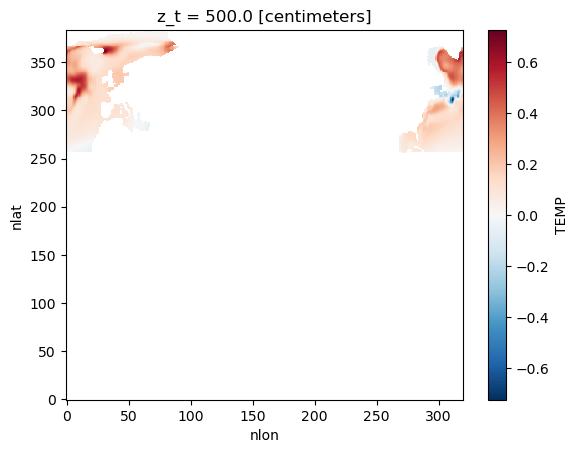

In [3]:
ds.TEMP.isel(z_t=0).plot()

In [4]:
ds.TLAT.isel(nlon=0, nlat=315).values

array(45.3365034)

get masks

In [5]:
grid_name = 'POP_gx1v7'

region_defs = {
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}        
    ]}
mask_lab_sea = pop_tools.region_mask_3d(grid_name, 
                                  region_defs=region_defs, 
                                  mask_name='Labrador Sea')
mask_lab_sea = mask_lab_sea.sum('region')  


region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [45.0, 66.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}        
    ]}
mask_spg = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='Subpolar Gyre')
mask_spg = mask_spg.sum('region')  

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Functions for metrics

In [43]:
## MOC at 55°N
# sMOC
ds_sMOC = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/sMOCcomposite.nc')
# stupid indexing nlat=(slice(250,365)); 
smoc_55N = ds_sMOC.densMOC.isel(nlat=340-250).max('sigma').values
# dMOC
da_dMOC = xr.open_dataarray('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/dMOCcomposite.nc')
dmoc_55N = da_dMOC.isel(nlat=340).max('z_t').values

## MOC at 45°N
# sMOC
smoc_45N = ds_sMOC.densMOC.isel(nlat=315-250).max('sigma').values
# dMOC
dmoc_45N = da_dMOC.isel(nlat=315).max('z_t').values

## MOC at 26°N
# sMOC
smoc_26N = ds_sMOC.densMOC.isel(nlat=270-250).max('sigma').values
# dMOC
dmoc_26N = da_dMOC.isel(nlat=270).max('z_t').values

## NAO
# mean annual signal
nao_annual = np.load(os.path.expanduser('~/phase1_CONDA/timeseries/nao_mean.npy'))
#mean DJF signal
nao_DJF = np.load(os.path.expanduser('~/phase1_CONDA/timeseries//DJF_nao_mean.npy'))

# atmospheric heat flux
ds_shf = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/SHFcomposite.nc').roll(nlon=+100).where(mask_lab_sea == 1)
shf_lab_sea_mean = ds_shf.SHF.mean(dim=('nlat', 'nlon')).values

# convection
ds_hmxl = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/HMXLcomposite.nc').roll(nlon=+100).where(mask_lab_sea == 1)
hmxl_lab_sea_mean = ds_hmxl.HMXL.mean(dim=('nlat', 'nlon')).values

# surface temperature Lab Sea
ds_temp = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TEMPcomposite.nc').roll(nlon=+100).where(mask_lab_sea == 1)
temp_surface_lab_mean = ds_temp.TEMP.isel(z_t=0).mean(dim=('nlat', 'nlon')).values

# 100m temperature Lab Sea
temp_100_lab_mean = ds_temp.TEMP.sel(z_t=slice(5.0000000e+02, 1.050000e+04)).mean(dim=('nlat', 'nlon', 'z_t')).values

# BSF
ds_bsf = xr.open_dataarray('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/BSFcomposite-test.nc').roll(nlon=+100).where(mask_spg == 1)
bsf_min_spg = ds_bsf.min(dim=('nlat', 'nlon')).values

# N_HEAT
n_heat_ds = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/N_HEATcomposite.nc')
n_heat_45N = n_heat_ds.N_HEAT.sel(lat_aux_grid=47.432735).values

# 1500m density Lab Sea
ds_sig_lab = xr.open_dataarray('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composites/sigma_composite_annual.nc').roll(nlon=+100).where(mask_lab_sea == 1)
ds_dz = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/rho/rho_1001.001.nc').roll(nlon=+100).where(mask_lab_sea == 1)
weighted_sigma = ds_sig_lab.sel(z_t=slice(500, 140049.7)) * ds_dz['dz'].sel(z_t=slice(500, 140049.7)) 
sum_weighted_sigma = weighted_sigma.sum(dim='z_t')
total_depth = ds_dz['dz'].sel(z_t=slice(500, 140049.7)).sum(dim='z_t')
sigma_lab_sea_mean = (sum_weighted_sigma/total_depth).mean(dim=['nlat', 'nlon']).values

In [44]:
# Windstress in Labrador Sea in March
ds_taux = xr.open_dataset(os.path.expanduser('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TAUXcomposite_march.nc'))
ds_taux = ds_taux.where(mask_lab_sea == 1)
ds_tauy = xr.open_dataset(os.path.expanduser('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TAUYcomposite_march.nc'))
ds_tauy = ds_tauy.where(mask_lab_sea == 1)
mag = (ds_taux.TAUX**2 + ds_tauy.TAUY**2)**0.5
tau_march_lab_mean = mag.mean(dim=('nlat', 'nlon')).values

In [45]:
# Windstress in Labrador Sea in Annual Mean
ds_taux = xr.open_dataset(os.path.expanduser('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TAUXcomposite_annual.nc'))
ds_taux = ds_taux.where(mask_lab_sea == 1)
ds_tauy = xr.open_dataset(os.path.expanduser('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TAUYcomposite_annual.nc'))
ds_tauy = ds_tauy.where(mask_lab_sea == 1)
mag = (ds_taux.TAUX**2 + ds_tauy.TAUY**2)**0.5
tau_annual_lab_mean = mag.mean(dim=('nlat', 'nlon')).values

In [46]:
# Load datasets
ds_taux = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TAUXcomposite_annual.nc')
ds_tauy = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/TAUYcomposite_annual.nc')
ds = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/rho/rho_1001.001.nc').isel(time=0).roll(nlon=+100)

# Mask data
ds_taux = ds_taux.where(mask_lab_sea == 1)
ds_tauy = ds_tauy.where(mask_lab_sea == 1)
ds = ds.where(mask_lab_sea == 1)
# checked: masks align

# Parameters
omega = 7.292124e-05 #ds.omega.values
R = 6.37122e+08*1e-2 #ds.radius.values*1e-2   # Convert from cm to m
rho_sw = 1.026*1e3 #ds.rho_sw.values*1e3      # Convert from g/cm³ to kg/m³
latitude = np.deg2rad(ds.ULAT.values)
# checked parameters

# Compute beta and f
beta = 2*omega*np.cos(latitude)/R
f = 2 * omega * np.sin(latitude)
# checked beta and f

In [47]:
# Prepare arrays to hold the time series of mean Sverdrup transport
time_series = ds_taux.time.values
DYU = ds.DYU.values *1e-2 # convert from cm to m
DXU = ds.DXU.values *1e-2 
# checked DXU and DYU
sverdrup_transport_time_series = []

# Loop over time steps
for t in range(len(time_series)):
    TAUX_t = ds_taux.TAUX.isel(time=t).values*1e-1 # convert from dyne/cm² to N/m²
    TAUY_t = ds_tauy.TAUY.isel(time=t).values*1e-1 # convert from dyne/cm² to N/m²
    
    # Gradients along latitude and longitude
    dTxdy = np.gradient(TAUX_t, axis=0) / DYU
    dTydx = np.gradient(TAUY_t, axis=1) / DXU

    # Wind stress curl
    curl_tau = dTydx - dTxdy

    # Sverdrup transport
    sverdrup_transport = (curl_tau/(rho_sw*beta)) + TAUX_t/(rho_sw*f)

    # Compute mean Sverdrup transport over Labrador Sea
    sverdrup_lab_mean = np.nanmean(sverdrup_transport)
    sverdrup_transport_time_series.append(sverdrup_lab_mean)

# Convert the time series list to a NumPy array
sverdrup_lab_mean = np.array(sverdrup_transport_time_series)

Text(0, 0.5, 'Annual wind stress [N/m^2]')

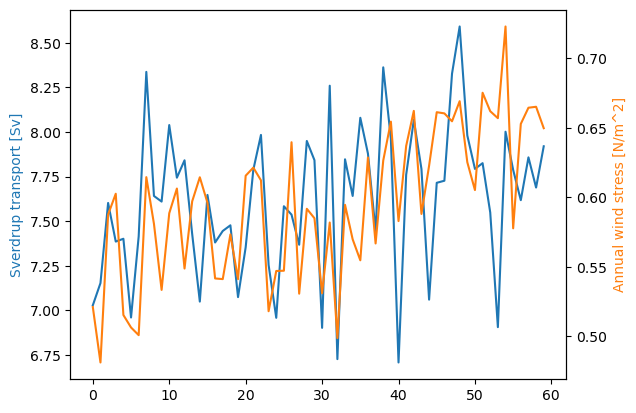

In [11]:
fig, ax1 = plt.subplots()


ax1.plot(sverdrup_lab_mean)
ax1.set_ylabel('Sverdrup transport [Sv]', color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(tau_annual_lab_mean, color='tab:orange')
ax2.set_ylabel('Annual wind stress [N/m^2]', color='tab:orange')

# Plot metrics

## Simple comparison plot

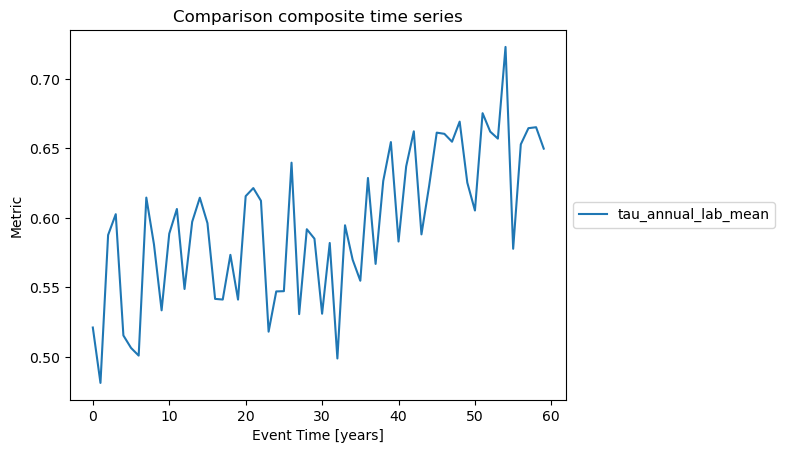

In [10]:
fig = plt.figure()

#plt.plot(smoc_55N, label='smoc_55N')

#plt.plot(dmoc_55N, label='dmoc_55N')

#plt.plot(smoc_45N, label='smoc_45N')

#plt.plot(dmoc_45N, label='dmoc_45N')

#plt.plot(smoc_26N, label='smoc_26N')

#plt.plot(dmoc_26N, label='dmoc_26N')

#plt.plot(nao_annual, label=r'Accumulated NAO index')

#plt.plot(-shf_lab_sea_mean, label=r'Surface Heat Flux average in Labrador Sea')

#plt.plot(hmxl_lab_sea_mean*1e-2, label=r'Mixed layer depth average in Labrador Sea')

#plt.plot(temp_surface_lab_mean, label=r'Surface temperature average in Labrador Sea')

#plt.plot(temp_100_lab_mean, label=r'Upper 100m temperature average in Labrador Sea')

#plt.plot(-bsf_min_spg, label=r'bsf_min_spg')

#plt.plot(n_heat_45N, label=r'n_heat_45N')

#plt.plot(sigma_lab_sea_mean, label=r'sigma_lab_sea_mean')

#plt.plot(tau_march_lab_mean, label=r'tau_march_lab_mean')

plt.plot(tau_annual_lab_mean, label=r'tau_annual_lab_mean')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r'Comparison composite time series')
plt.xlabel('Event Time [years]')
plt.ylabel('Metric')
plt.show()

## Stream functions comparison

/home/innag3580/.conda/envs/movie/lib/python3.10/site-packages/matplotlib/axis.py:125: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labelcolor == 'inherit':


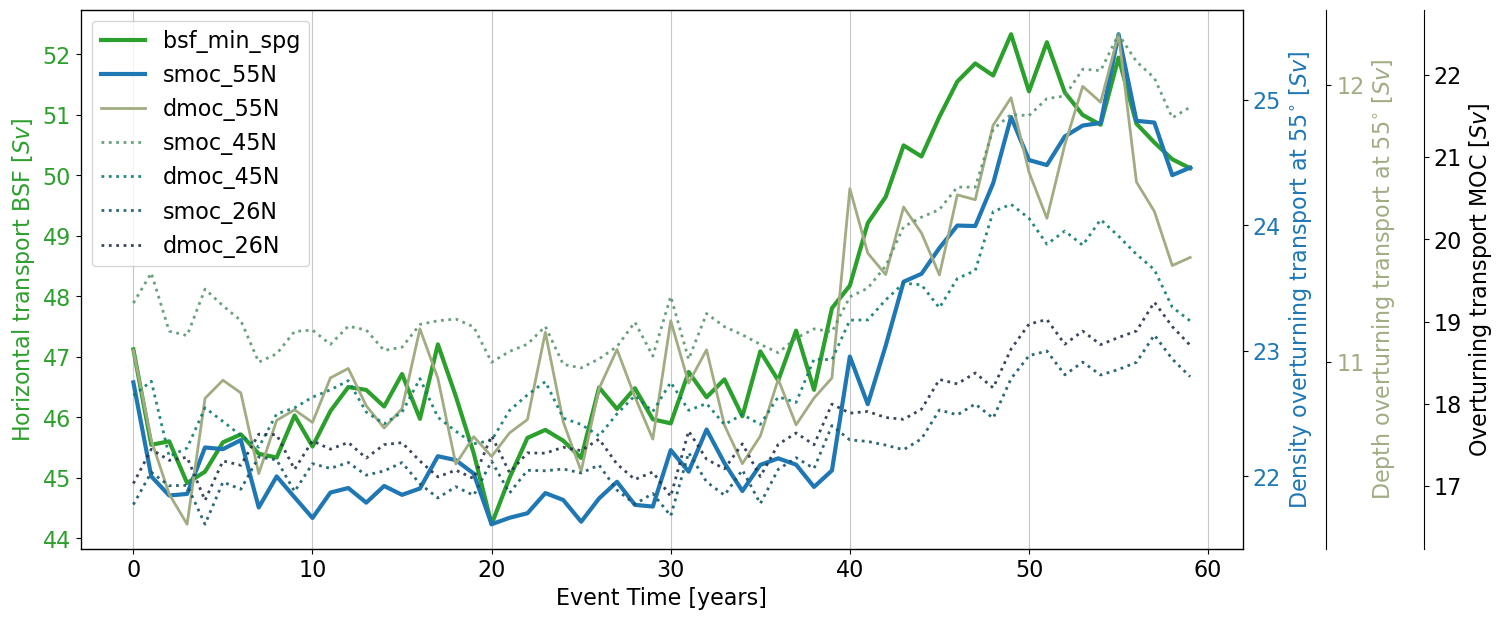

In [48]:
fig, ax1 = plt.subplots(figsize=(15, 7))

colors = cmo.rain(np.linspace(0.3, 0.9, 5))

# Plot bsf_min_spg on ax1
color = 'tab:green'
ax1.plot(-bsf_min_spg, label='bsf_min_spg', color=color, linewidth=3)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Horizontal transport BSF [$Sv$]', color=color)

# Plot smoc_55N on ax2
color = 'tab:blue'
ax2 = ax1.twinx()
ax2.spines["left"].set_position(("axes", 1))
ax2.plot(smoc_55N, label='smoc_55N', color=color, linewidth=3)
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Density overturning transport at 55$^{\circ}$ [$Sv$]', color=color)
ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plot dmoc_55N on ax3
color = colors[0]
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))
ax3.plot(dmoc_55N, label='dmoc_55N', color=color, linewidth=2)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylabel('Depth overturning transport at 55$^{\circ}$ [$Sv$]', color=color)
ax3.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plot additional data on ax4
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 130))
ax4.plot(smoc_45N, label='smoc_45N', color=colors[1], alpha=0.9, linestyle=':', linewidth=2)
ax4.plot(dmoc_45N, label='dmoc_45N', color=colors[2], alpha=0.9, linestyle=':', linewidth=2)
ax4.plot(smoc_26N, label='smoc_26N', color=colors[3], alpha=0.9, linestyle=':', linewidth=2)
ax4.plot(dmoc_26N, label='dmoc_26N', color=colors[4], alpha=0.9, linestyle=':', linewidth=2)
ax4.tick_params(axis='y', labelcolor='black')
ax4.set_ylabel('Overturning transport MOC [$Sv$]', color='black')

# Set common x-axis label
ax1.set_xlabel('Event Time [years]')
ax1.xaxis.grid(True, alpha=0.7)

# Move the legend to the upper left corner
lns1 = ax1.get_lines()
lns2 = ax2.get_lines()
lns3 = ax3.get_lines()
lns4 = ax4.get_lines()
lns = lns1 + lns2 + lns3 + lns4
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper left')

plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'compare_STF_metrics.png', bbox_inches='tight')

# Find triggers

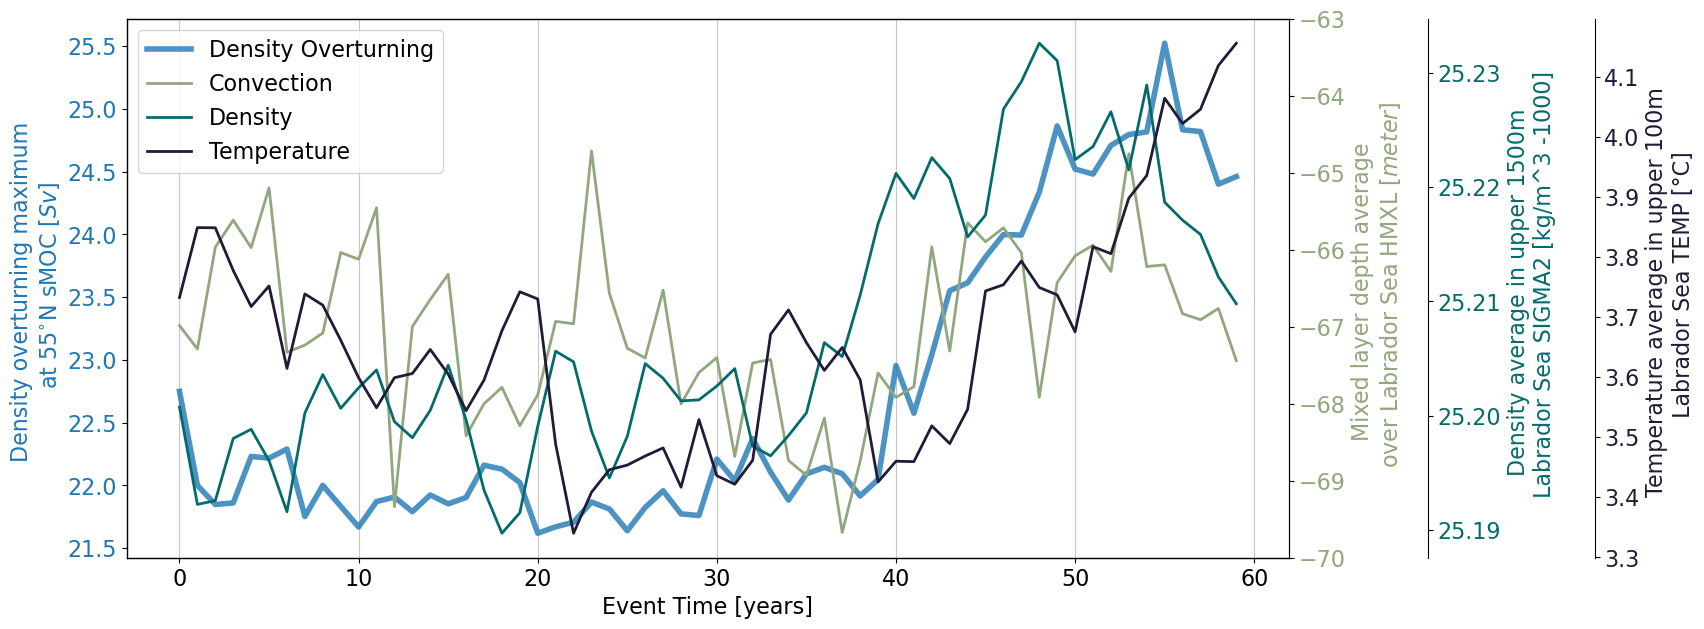

In [176]:
# SMOC 55
# HMXL
# DENS
# TEMP 100

plt.rc('font', size=16)

fig, ax1 = plt.subplots(figsize=(15, 7))
colors = cmo.rain(np.linspace(0, 1, 4))

color = 'tab:blue'
ax1.set_xlabel('Event Time [years]')
ax1.set_ylabel('Density overturning maximum \n at 55$^{\circ}$N sMOC [$Sv$]', color=color)
ax1.plot(smoc_55N, color=color, label='Density Overturning', linewidth=4, alpha=0.8)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = colors[1]
ax2.spines['right'].set_position(('outward', 0))  
ax2.set_ylabel('Mixed layer depth average \n over Labrador Sea HMXL [$meter$]', color=color)  
ax2.plot(-hmxl_lab_sea_mean*0.01, color=color, label=r'Convection', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-70, -63)

ax3 = ax1.twinx()  
color = colors[2]
ax3.spines['right'].set_position(('outward', 100))  
ax3.set_ylabel('Density average in upper 1500m \n Labrador Sea SIGMA2 [kg/m^3 -1000]', color=color)  
ax3.plot(sigma_lab_sea_mean, color=color, label='Density', linewidth=2)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax1.twinx()  
color = colors[3]
ax4.spines['right'].set_position(('outward', 220))  
ax4.set_ylabel('Temperature average in upper 100m \n Labrador Sea TEMP [°C]', color=color)  
ax4.plot(temp_100_lab_mean, color=color, label=r'Temperature', linewidth=2)
ax4.tick_params(axis='y', labelcolor=color)

#plt.title('Comparison composite time series')

lns1 = ax1.get_lines()
lns2 = ax2.get_lines()
lns3 = ax3.get_lines()
lns4 = ax4.get_lines()
lns = lns1 + lns2 + lns3 + lns4
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper left')

ax1.xaxis.grid(True, alpha=0.7)
#fig.tight_layout()  

plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'Figure_3.1.png', bbox_inches='tight')

In [ ]:
# N_HEAT
# NAO
# SHF
# WIND

plt.rc('font', size=16)

fig, ax1 = plt.subplots(figsize=(15, 7))
colors = cmo.speed(np.linspace(0.3, 0.9, 4))

color = colors[3]
ax1.set_xlabel('Event Time [years]')
ax1.set_ylabel('Ocean Northward Heat Transport \n at 45°N N_HEAT [PW]', color=color)
ax1.plot(n_heat_45N, color=color, label='Northward Heat Transport$', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = colors[2]
ax2.spines['right'].set_position(('outward', 0))  
ax2.set_ylabel('Normalised Cummulative Winter \n North Atlantic Oscilation NAO', color=color)  
ax2.plot(nao_annual, color=color, label=r'DJF cummulative NAO', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  
color = colors[1]
ax3.spines['right'].set_position(('outward', 100))  
ax3.set_ylabel('Surface Heat Flux average \n in Labrador Sea [W/m^2]', color=color)  
ax3.plot(-shf_lab_sea_mean, color=color, label=r'Surface Heat Flux', linewidth=2)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylim(65, 105)

ax4 = ax1.twinx()  
color = colors[0]
ax4.spines['right'].set_position(('outward', 200))  
ax4.set_ylabel('Wind Stress average \n at Labrador Sea TAU [N/m^2]', color=color)  
ax4.plot(tau_annual_lab_mean, color=color, label=r'Wind Stress', linewidth=2)
ax4.tick_params(axis='y', labelcolor=color)

#plt.title('Comparison composite time series')

#lns1 = ax1.get_lines()
#lns2 = ax2.get_lines()
lns3 = ax3.get_lines()
lns4 = ax4.get_lines()
#lns = lns1 + lns2 + lns3 + lns4
lns = lns3 + lns4
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper left')

ax1.xaxis.grid(True, alpha=0.7)
fig.tight_layout()  

plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'Figure_3.2.png', bbox_inches='tight')

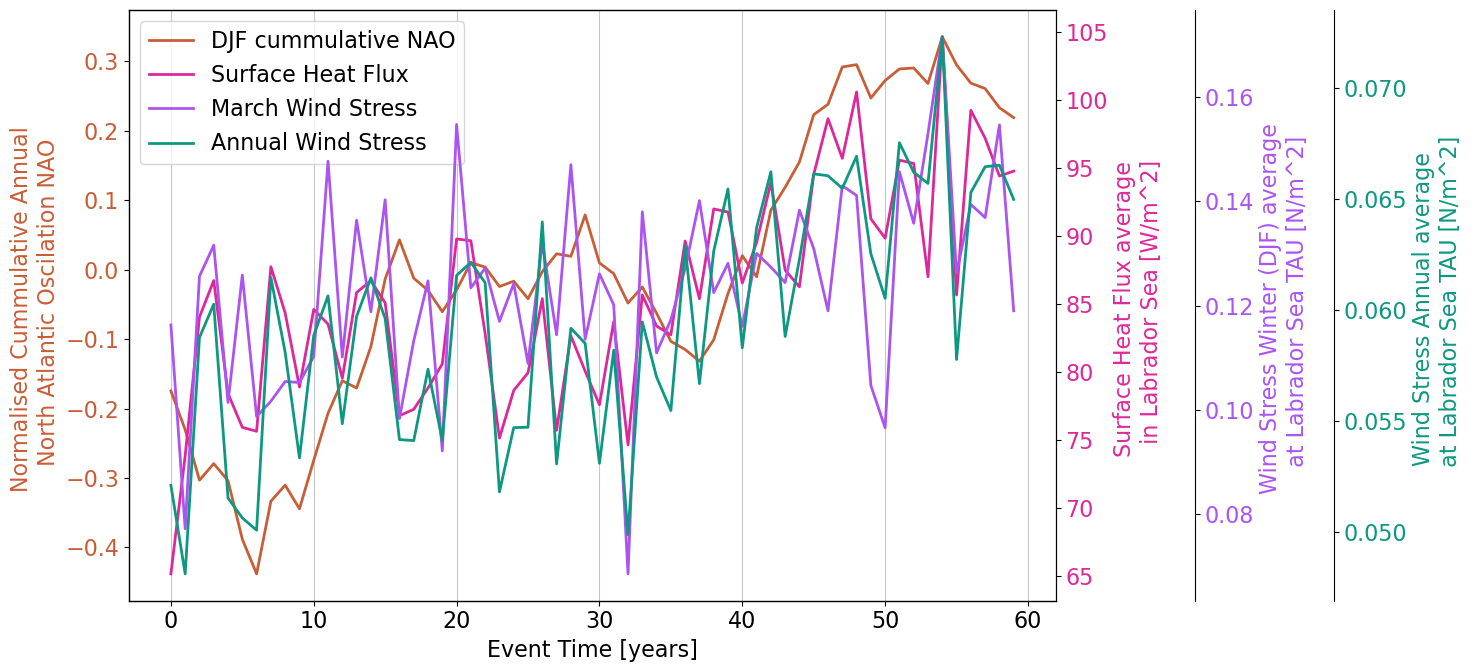

In [35]:
# NAO
# SHF
# TAU annual
# TAU winter

plt.rc('font', size=16)

fig, ax1 = plt.subplots(figsize=(15, 7))
colors = cmo.phase(np.linspace(0.1, 0.9, 6))

color = colors[0]
ax1.set_xlabel('Event Time [years]')
ax1.set_ylabel('Normalised Cummulative Annual \n North Atlantic Oscilation NAO', color=color)  
ax1.plot(nao_annual, color=color, label=r'DJF cummulative NAO', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = colors[1]
ax2.spines['right'].set_position(('outward', 0))  
ax2.set_ylabel('Surface Heat Flux average \n in Labrador Sea [W/m^2]', color=color)  
ax2.plot(-shf_lab_sea_mean, color=color, label=r'Surface Heat Flux', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  
color = colors[2]
ax3.spines['right'].set_position(('outward', 100))  
ax3.set_ylabel('Wind Stress Winter (DJF) average \n at Labrador Sea TAU [N/m^2]', color=color)  
ax3.plot(tau_march_lab_mean*1e-1, color=color, label=r'March Wind Stress', linewidth=2)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax1.twinx()  
color = colors[4]
ax4.spines['right'].set_position(('outward', 200))  
ax4.set_ylabel('Wind Stress Annual average \n at Labrador Sea TAU [N/m^2]', color=color)  
ax4.plot(tau_annual_lab_mean*1e-1, color=color, label=r'Annual Wind Stress', linewidth=2)
ax4.tick_params(axis='y', labelcolor=color)

#plt.title('Comparison composite time series')

lns1 = ax1.get_lines()
lns2 = ax2.get_lines()
lns3 = ax3.get_lines()
lns4 = ax4.get_lines()
lns = lns1 + lns2 + lns3 + lns4
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper left')

ax1.xaxis.grid(True, alpha=0.7)
fig.tight_layout()  

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'NAO_TAU_SHF_comparison.png', bbox_inches='tight')

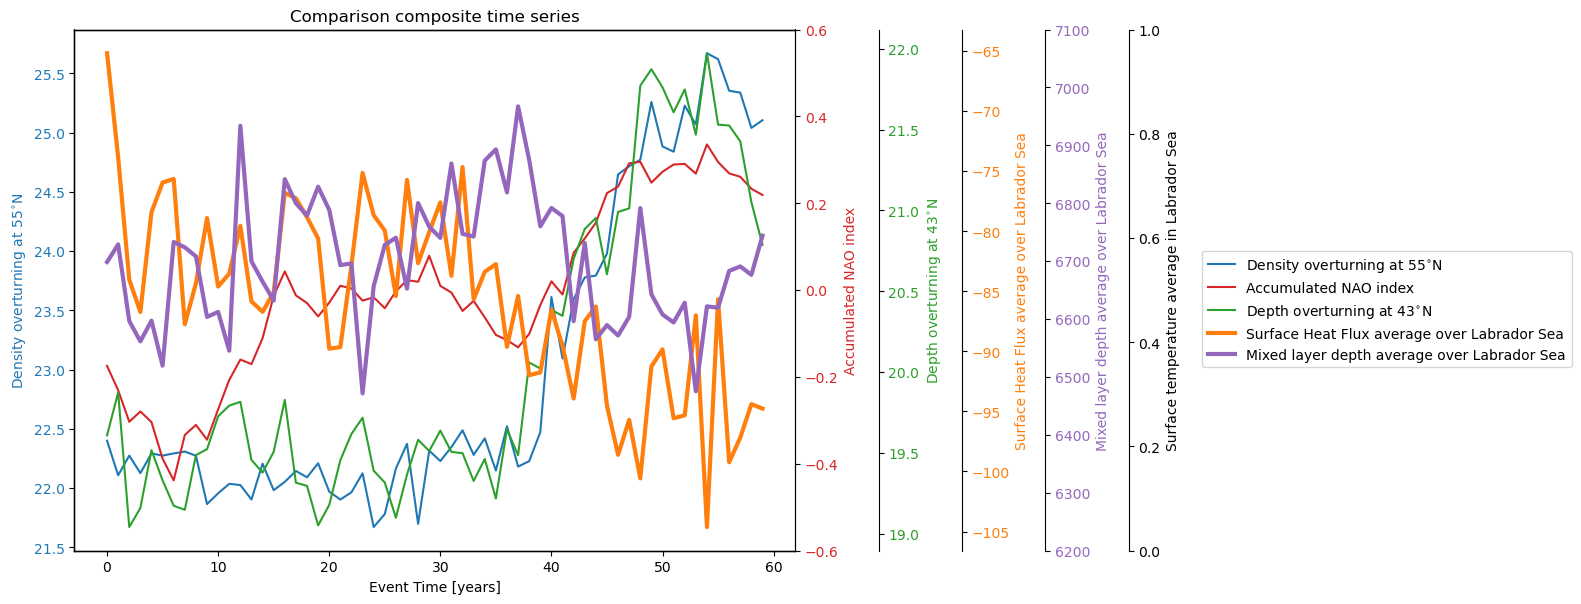

In [37]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Event Time [years]')
ax1.set_ylabel('Density overturning at 55$^{\circ}$N', color=color)
ax1.plot(spg_dens_mean, color=color, label='Density overturning at 55$^{\circ}$N')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Accumulated NAO index', color=color)  
ax2.plot(nao_annual, color=color, label='Accumulated NAO index')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-0.6, 0.6)  # Limit the y-axis from -2 to 2 for nao_annual

ax3 = ax1.twinx()  
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))  
ax3.set_ylabel('Depth overturning at 43$^{\circ}$N', color=color)  
ax3.plot(dmoc_43N_mean, color=color, label='Depth overturning at 43$^{\circ}$N')
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax1.twinx()  
color = 'tab:orange'
ax4.spines['right'].set_position(('outward', 120))  
ax4.set_ylabel('Surface Heat Flux average over Labrador Sea', color=color)  
ax4.plot(shf_lab_sea_mean, color=color, label='Surface Heat Flux average over Labrador Sea', linewidth=3)
ax4.tick_params(axis='y', labelcolor=color)

ax5 = ax1.twinx()  
color = 'tab:purple'
ax5.spines['right'].set_position(('outward', 180))  
ax5.set_ylabel('Mixed layer depth average over Labrador Sea', color=color)  
ax5.plot(hmxl_lab_sea_mean, color=color, label='Mixed layer depth average over Labrador Sea', linewidth=3)
ax5.tick_params(axis='y', labelcolor=color)
ax5.set_ylim(6200, 7100)

ax6 = ax1.twinx()  
color = 'black'
ax6.spines['right'].set_position(('outward', 240))  
ax6.set_ylabel('Surface temperature average in Labrador Sea', color=color)  
#ax6.plot(temp_surface_lab_mean, color=color, label='Surface temperature average in Labrador Sea', linewidth=2)
ax6.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Comparison composite time series')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.show()

plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'compare_metrics_3.png', bbox_inches='tight')

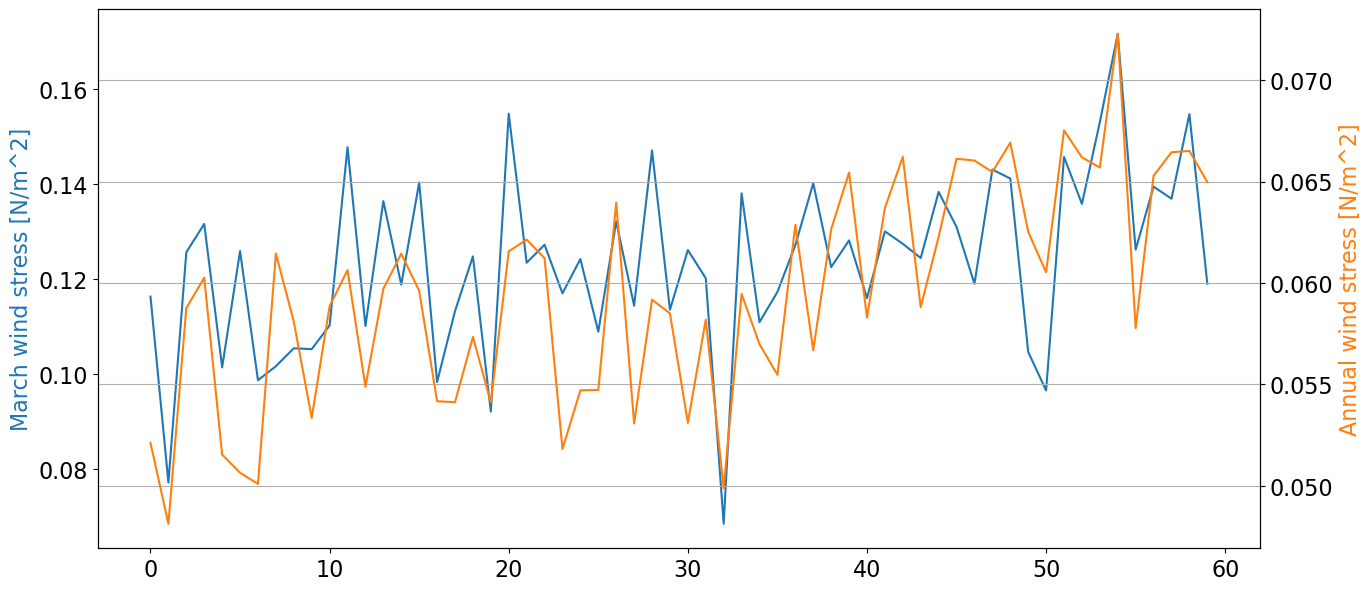

In [19]:
fig, ax1 = plt.subplots(figsize=(15, 7))
plt.rc('font', size=16)

ax1.plot(tau_march_lab_mean*1e-1)
ax1.set_ylabel('March wind stress [N/m^2]', color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(tau_annual_lab_mean*1e-1, color='tab:orange')
ax2.set_ylabel('Annual wind stress [N/m^2]', color='tab:orange')

plt.xlabel('Event Time [Years]')
plt.grid()
plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'STF_SHF_delta_comparison.png', bbox_inches='tight')

# Final comparison plot

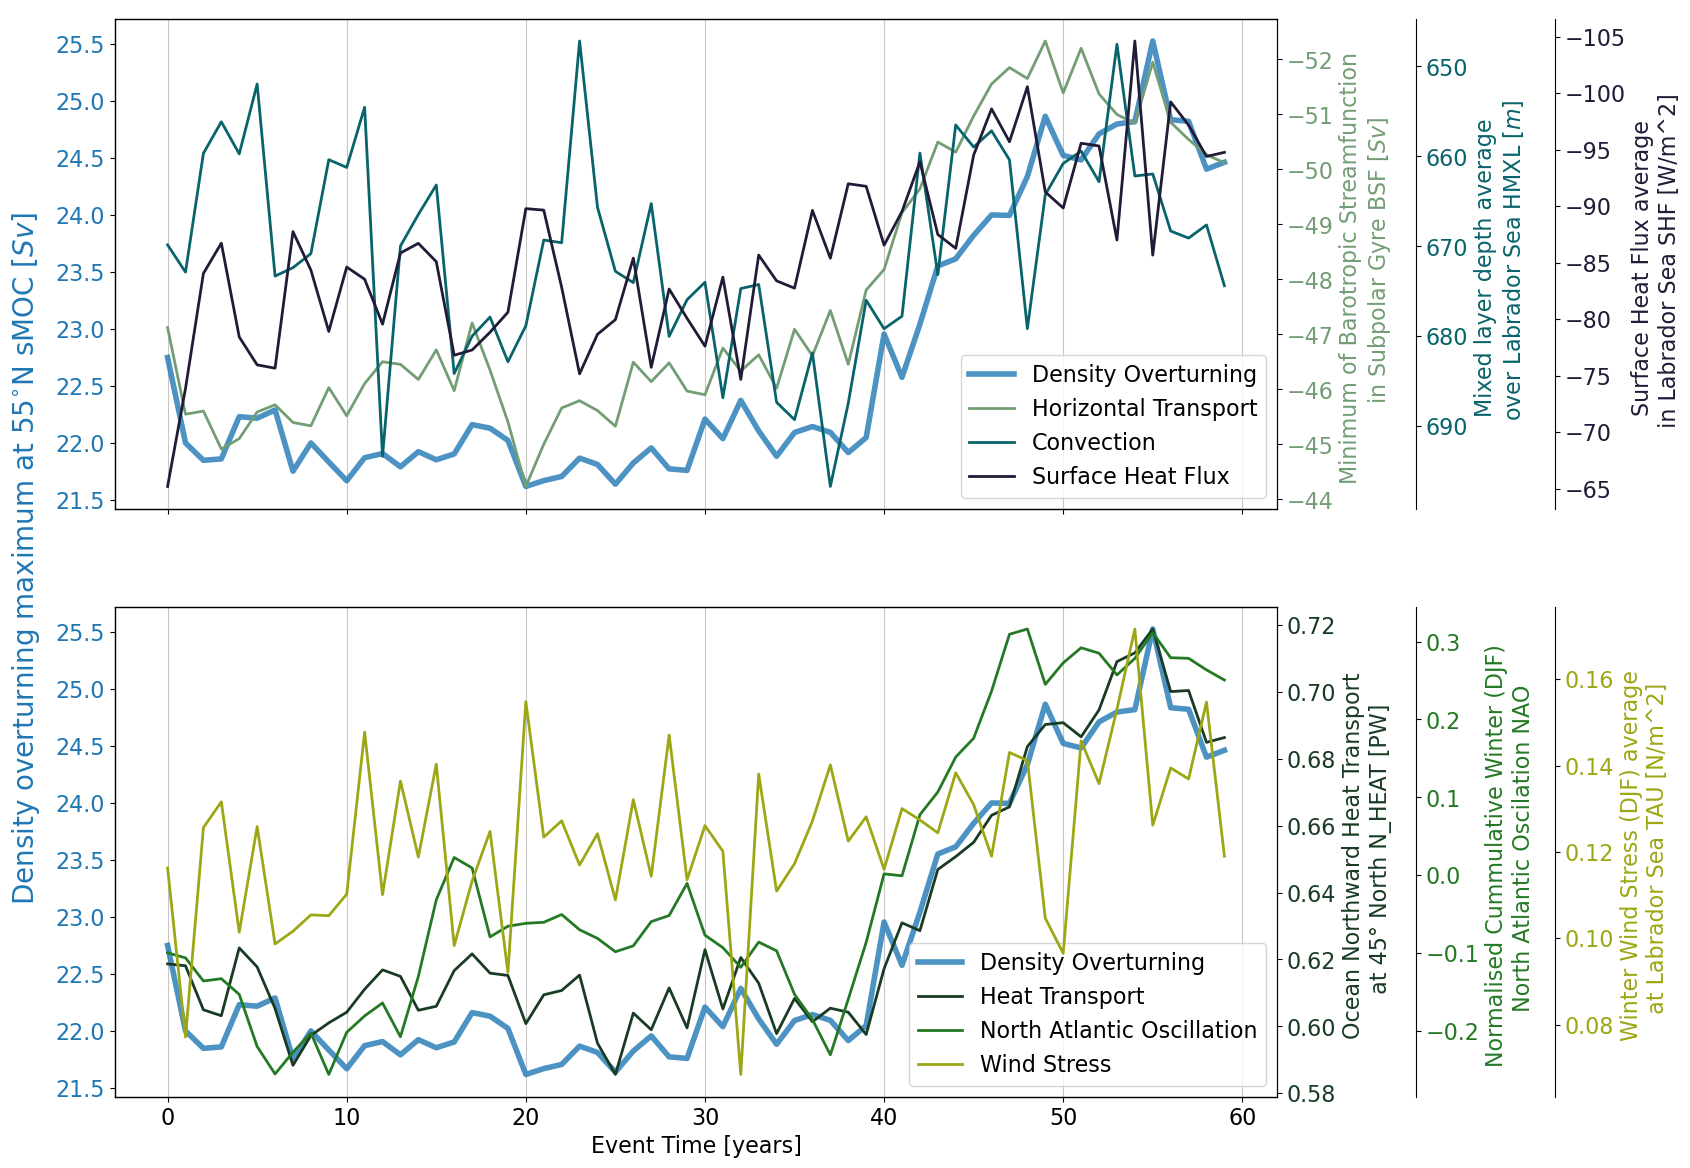

In [40]:
plt.rc('font', size=16)
colors1 = cmo.rain(np.linspace(0.1, 1, 4))
colors2 = cmo.speed(np.linspace(0.1, 0.9, 4))

# Create a subplot grid of 2 rows and 1 column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 14), sharex=True, sharey=True)

# Overall Y label
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel('Density overturning maximum at 55$^{\circ}$N sMOC [$Sv$]', labelpad=20, color='tab:blue', fontsize=20)

color = 'tab:blue'
ax1.plot(smoc_55N, color=color, label='Density Overturning', linewidth=4, alpha=0.8)
ax1.tick_params(axis='y', labelcolor=color)

ax1_1 = ax1.twinx()  
color = colors1[1]
ax1_1.spines['right'].set_position(('outward', 0))  
ax1_1.set_ylabel('Minimum of Barotropic Streamfunction \n in Subpolar Gyre BSF [$Sv$]', color=color)  
ax1_1.plot(bsf_min_spg, color=color, label=r'Horizontal Transport', linewidth=2)
ax1_1.invert_yaxis() 
ax1_1.tick_params(axis='y', labelcolor=color)

ax1_2 = ax1.twinx()  
color = colors1[2]
ax1_2.spines['right'].set_position(('outward', 100))  
ax1_2.set_ylabel('Mixed layer depth average \n over Labrador Sea HMXL [$m$]', color=color)  
ax1_2.plot(hmxl_lab_sea_mean*1e-1, color=color, label=r'Convection', linewidth=2)
ax1_2.invert_yaxis() 
ax1_2.tick_params(axis='y', labelcolor=color)

ax1_3 = ax1.twinx()  
color = colors1[3]
ax1_3.spines['right'].set_position(('outward', 200))  
ax1_3.set_ylabel('Surface Heat Flux average \n in Labrador Sea SHF [W/m^2]', color=color)  
ax1_3.plot(shf_lab_sea_mean, color=color, label=r'Surface Heat Flux', linewidth=2)
ax1_3.invert_yaxis() 
ax1_3.tick_params(axis='y', labelcolor=color)

lns1 = ax1.get_lines()
lns2 = ax1_1.get_lines()
lns3 = ax1_2.get_lines()
lns4 = ax1_3.get_lines()
lns = lns1 + lns2 + lns3 + lns4
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='lower right')
ax1.xaxis.grid(True, alpha=0.7)              
                
color = 'tab:blue'
ax2.set_xlabel('Event Time [years]')
ax2.plot(smoc_55N, color=color, label='Density Overturning', linewidth=4, alpha=0.8)
ax2.tick_params(axis='y', labelcolor=color)

ax2_1 = ax2.twinx()  
color = colors2[3]
ax2_1.spines['right'].set_position(('outward', 0))  
ax2_1.set_ylabel('Ocean Northward Heat Transport \n at 45° North N_HEAT [PW]', color=color) 
ax2_1.plot(n_heat_45N, color=color, label=r'Heat Transport', linewidth=2)
ax2_1.tick_params(axis='y', labelcolor=color)

ax2_2 = ax2.twinx()  
color = colors2[2]
ax2_2.spines['right'].set_position(('outward', 100))  
ax2_2.set_ylabel('Normalised Cummulative Winter (DJF) \n North Atlantic Oscilation NAO', color=color)  
ax2_2.plot(nao_DJF, color=color, label=r'North Atlantic Oscillation', linewidth=2)
ax2_2.tick_params(axis='y', labelcolor=color)

ax2_3 = ax2.twinx()  
color = colors2[1]
ax2_3.spines['right'].set_position(('outward', 200))  
ax2_3.set_ylabel('Winter Wind Stress (DJF) average \n at Labrador Sea TAU [N/m^2]', color=color)  
ax2_3.plot(tau_march_lab_mean*1e-1, color=color, label=r'Wind Stress', linewidth=2)
ax2_3.tick_params(axis='y', labelcolor=color)

lns1 = ax2.get_lines()
lns2 = ax2_1.get_lines()
lns3 = ax2_2.get_lines()
lns4 = ax2_3.get_lines()
lns = lns1 + lns2 + lns3 + lns4
labels = [l.get_label() for l in lns]
ax2.legend(lns, labels, loc='lower right')

ax2.xaxis.grid(True, alpha=0.7)
#fig.tight_layout()  
plt.show()